In [ ]:
# default_exp funcs.train_ae

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
from decode_fish.funcs.train_sl import eval_logger, load_from_eval_dict

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def train_ae(model, 
             dl, 
             num_iter,
             optim_net, 
             optim_psf, 
             sched_net, 
             sched_psf, 
             min_int,
             microscope,
             log_interval,
             save_dir, 
             log_dir,
             psf=None,
             bl_loss_scale = 0.01,
             p_quantile=0,
             grad_clip=0.01,
             eval_dict=None):
    
    save_dir = Path(save_dir)
    writer = SummaryWriter(log_dir)
    
    if eval_dict is not None:
        eval_img, eval_df = load_from_eval_dict(eval_dict)

    model.cuda().train()
    
    for batch_idx in range(num_iter):
        x, local_rate, background = next(iter(dl))

        """GET SUPVERVISED LOSS"""
        locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape = PointProcessUniform(local_rate, min_int=min_int).sample()
        xsim = microscope(locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape)
        xsim_noise = microscope.noise(xsim, background).sample()

        res_sim = model(xsim_noise)
        gmm_loss = -PointProcessGaussian(logits = res_sim['logits'],xyzi_mu=res_sim['xyzi_mu'],xyzi_sigma = res_sim['xyzi_sigma']).log_prob(locs_sl,x_os_sl, y_os_sl, z_os_sl, ints_sl, p_quantile).mean()

        background_loss = F.mse_loss(res_sim['background'], background)

        loss = gmm_loss  + bl_loss_scale * background_loss
        """"""
        loss.backward()
        
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip, norm_type=2)

        optim_net.step()
        optim_net.zero_grad()
        
        
        res_img = model(x)
        
        ae_img = microscope(*model_output_to_micro_input(res_img, threshold=0.1))
        
        log_p_x_given_z = - microscope.noise(ae_img,res_img['background']).log_prob(x).mean()

#         print(len(locs_ae[0]))
        log_p_x_given_z.backward()
        
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(optim_psf.param_groups[0]['params'], max_norm=grad_clip, norm_type=2)

        optim_psf.step()
        optim_psf.zero_grad()
        
        if sched_net:
            sched_net.step()
            
        if sched_psf:
            sched_psf.step()
            

        writer.add_scalar('SL Losses/gmm_loss', gmm_loss.detach().cpu(), batch_idx)
        writer.add_scalar('SL Losses/bg_loss', background_loss.detach().cpu(), batch_idx)

        writer.add_scalar('AE Losses/p_x_given_z', log_p_x_given_z.detach().cpu(), batch_idx)
        
        if batch_idx % log_interval == 0 and writer is not None:

            with torch.no_grad():
                pred_df = model_output_to_df(res_sim, 0.1)
                target_df = sample_to_df(locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl)

                if eval_dict is not None:
                    res_eval = model(eval_img[None].cuda())
                    ae_img = microscope(*model_output_to_micro_input(res_eval, threshold=0.1))
                    pred_eval_df = model_output_to_df(res_eval, 0.1, px_size=eval_dict['px_size'])
                    free_mem()

            if writer is not None:
                eval_logger(writer, pred_df, target_df, batch_idx, data_str='Sim. ')
                if eval_df is not None:
                    eval_logger(writer, pred_eval_df, eval_df, batch_idx, data_str='Inp. ')

            sl_fig = sl_plot(x, xsim_noise, background, res_sim)
            plt.show()

            if eval_dict is not None:
                eval_fig = gt_plot(eval_img, pred_eval_df, eval_df, eval_dict['px_size'],ae_img[0]+res_eval['background'][0])
                plt.show()

            if writer is not None:
                writer.add_figure('SL summary', sl_fig, batch_idx)
                if eval_dict is not None:
                    writer.add_figure('GT', eval_fig, batch_idx)

            #storingv
            torch.save({'state_dict':model.state_dict(), 'scaling':[model.unet.inp_scale, model.unet.inp_offset]}, str(save_dir) +'/model_ae.pkl')
            torch.save(microscope.state_dict(), str(save_dir) + '/microscope_ae.pkl')
            torch.save(psf.state_dict(), str(save_dir) + '/psf_ae.pkl' )
            torch.save(optim_psf.state_dict(), str(save_dir) + '/opt_ae.pkl' )

In [ ]:
cfg = OmegaConf.load('../config/experiment/N2_352_2.yaml')
# cfg =OmegaConf.load(default_conf)
psf, noise, micro = load_psf_micro_psf_noise(cfg)

In [ ]:
img_3d = load_tiff_image(cfg.data_path.image_path)[0]
estimate_backg = hydra.utils.instantiate(cfg.bg_estimation)
roi_mask       = get_roi_mask(img_3d, tuple(cfg.roi_mask.pool_size), percentile= cfg.roi_mask.percentile)
rand_crop      = RandomCrop3D((cfg.random_crop.crop_sz,cfg.random_crop.crop_sz,cfg.random_crop.crop_sz), roi_mask)

In [ ]:
probmap_generator = ScaleTensor(low=cfg.prob_generator.low, 
                                high=cfg.prob_generator.high, 
                                data_min = img_3d.min(), 
                                data_max = img_3d.max())

ds = DecodeDataset(path = cfg.data_path.image_path,
                   dataset_tfms =  [rand_crop], 
                   rate_transform = probmap_generator, 
                   bg_transform = estimate_backg, 
                   device='cuda:0', 
                   num_iter=cfg.dataloader.num_iter * cfg.dataloader.bs) 

decode_dl = DataLoader(ds, batch_size=2, num_workers=0)

In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d)
micro = Microscope(parametric_psf=[psf], noise=noise, multipl=cfg.microscope.multipl).cuda()

psf  .to('cuda')
micro.to('cuda')

Microscope(
  (noise): sCMOS()
)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

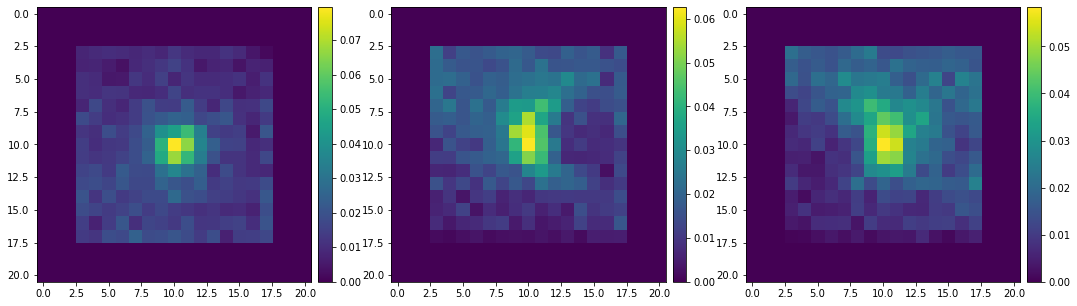

In [ ]:
plot_3d_projections(psf.psf_volume[0])

In [ ]:
    if cfg.evaluation is not None:
        eval_dict = dict(cfg.evaluation)
        eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
        eval_dict['px_size'] = list(eval_dict['px_size'])
    else:
        eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

OmegaConf.save(cfg, cfg.output.save_dir + '/train.yaml')

In [ ]:
model_sl = load_model_state(cfg, 'model_sl.pkl').cuda()
micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope_sl.pkl'))
opt_sl = AdamW(model_sl.parameters(), lr=cfg.supervised.lr)
opt_sl.load_state_dict(torch.load(Path(cfg.output.save_dir)/'opt_sl.pkl'))
scheduler_sl = torch.optim.lr_scheduler.StepLR(opt_sl, step_size=1000, gamma=0.5)

ae_param = list(micro.parameters())  + list(psf.parameters())
opt_ae  = AdamW(ae_param, lr=1e-5)
scheduler_ae = torch.optim.lr_scheduler.StepLR(opt_ae, step_size=1000, gamma=0.5)

In [ ]:
gt_img, gt_df = load_from_eval_dict(eval_dict)

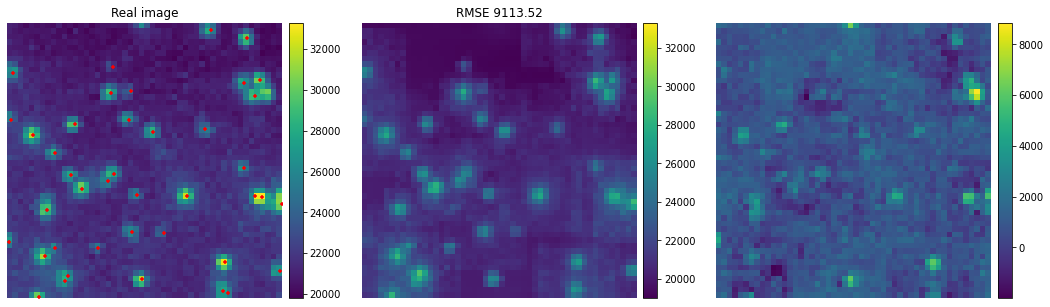

In [ ]:
with torch.no_grad():
    res_gt = model_sl(gt_img[None].cuda())
    locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae = model_output_to_micro_input(res_gt, threshold=0.1)
    ae_img = micro(locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae)
    pred_gt_df = model_output_to_df(res_gt, 0.1, px_size=eval_dict['px_size'])
    free_mem()

    gt_fig = gt_plot(gt_img, pred_gt_df, gt_df, eval_dict['px_size'],ae_img[0]+res_gt['background'][0])
    plt.show()

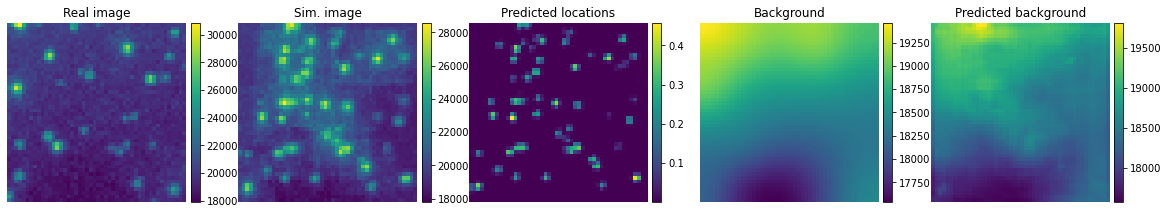

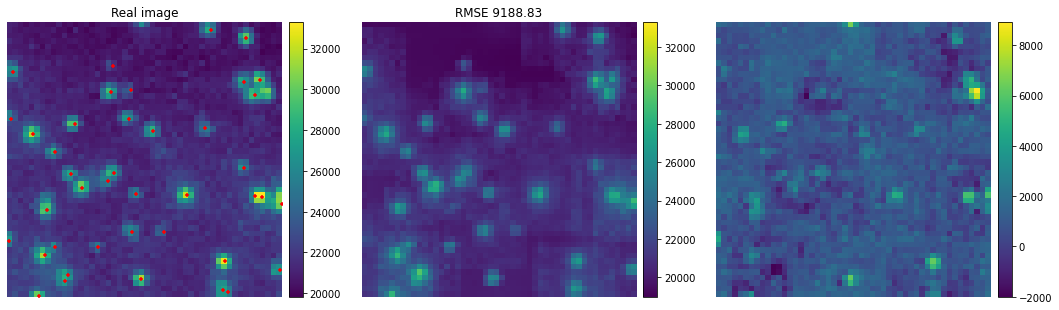

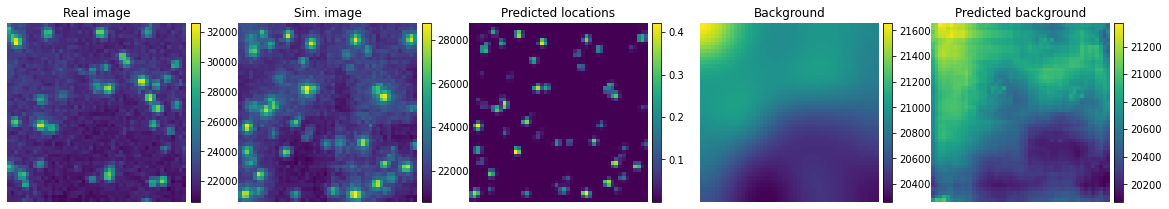

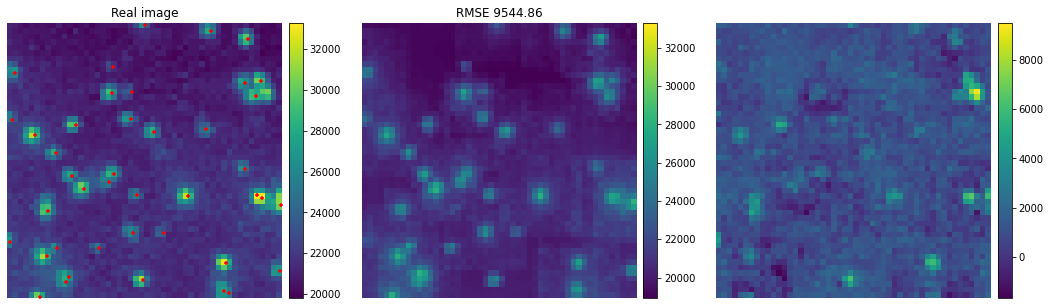

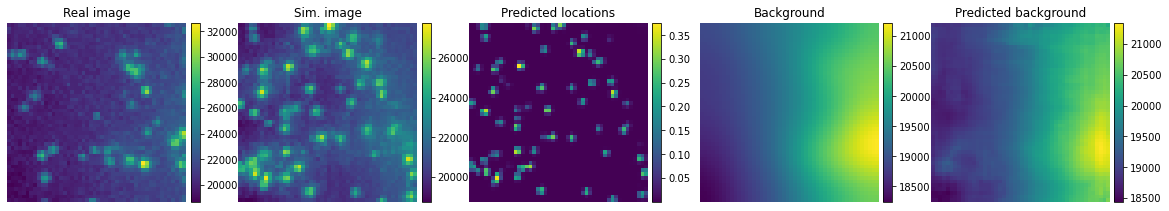

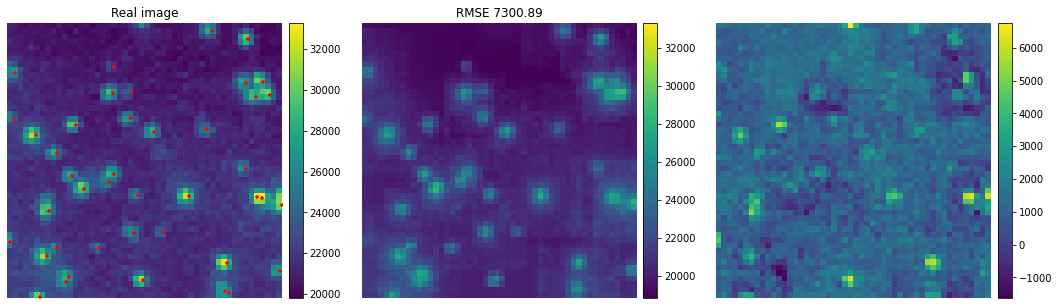

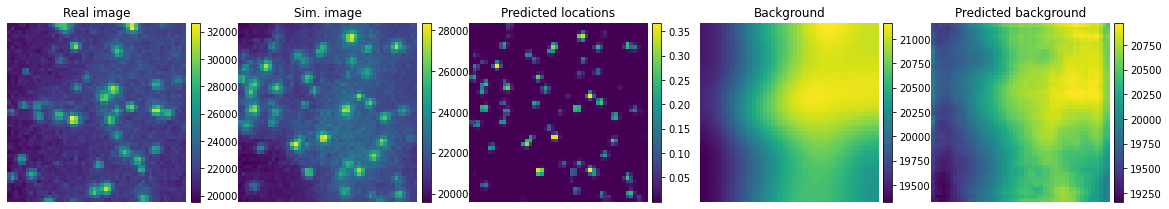

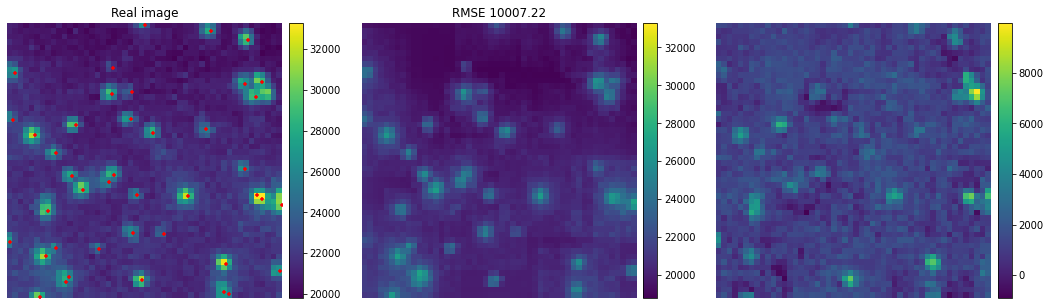

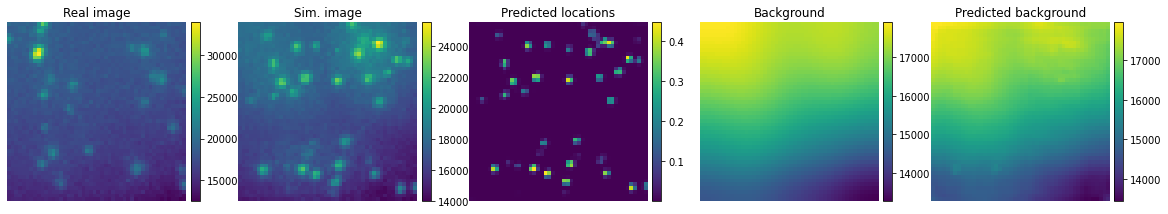

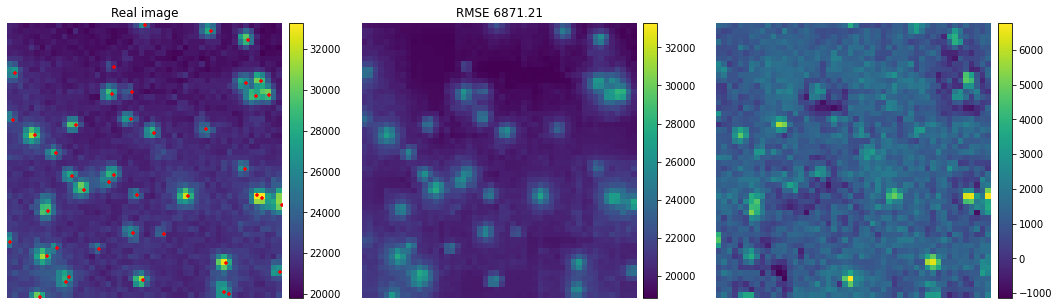

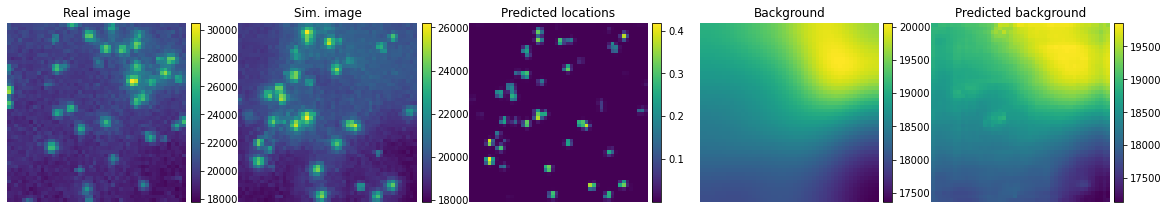

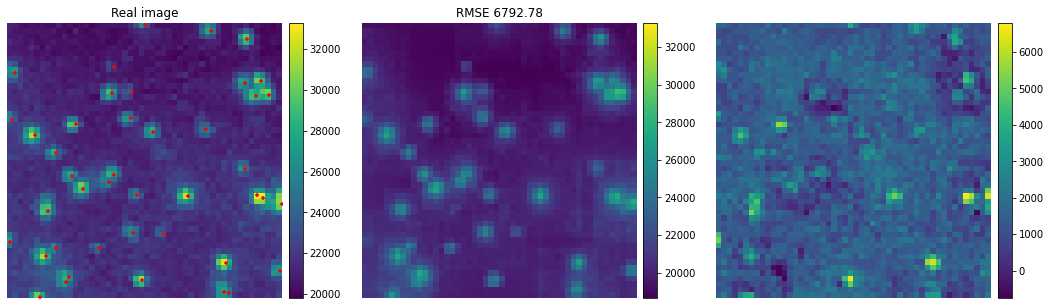

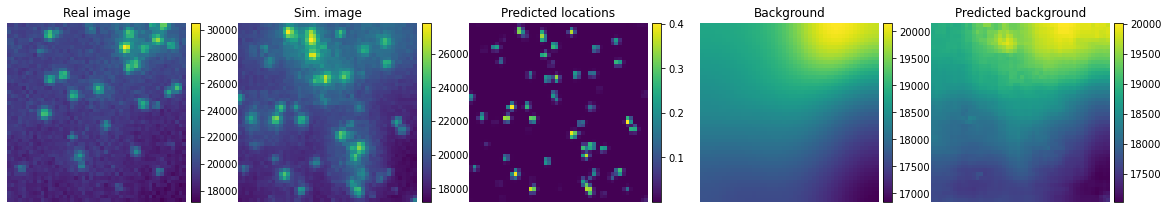

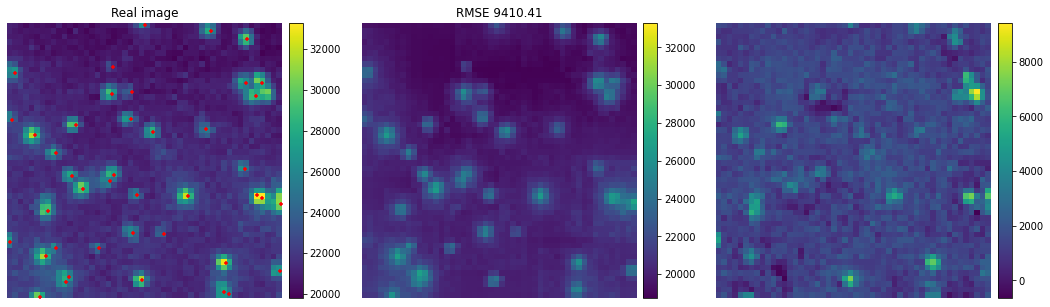

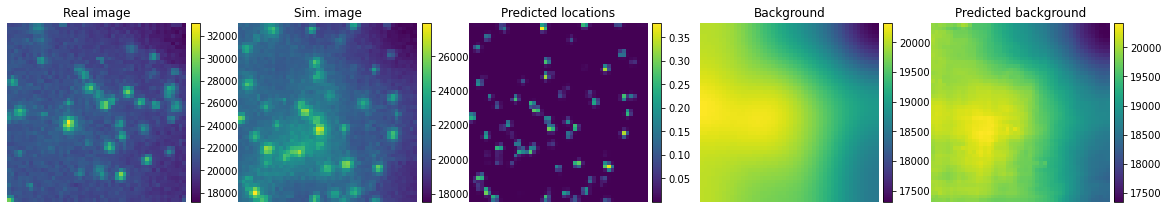

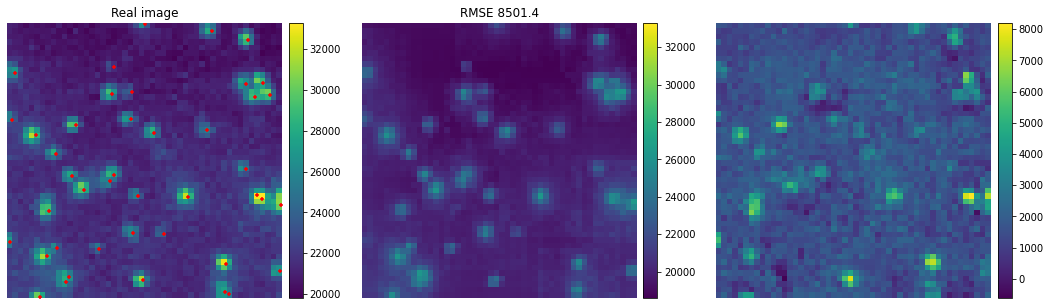

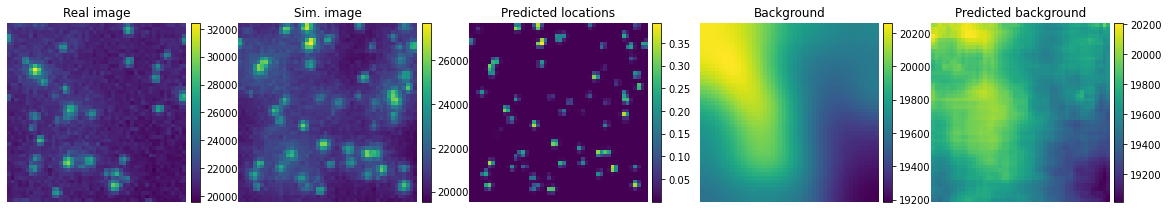

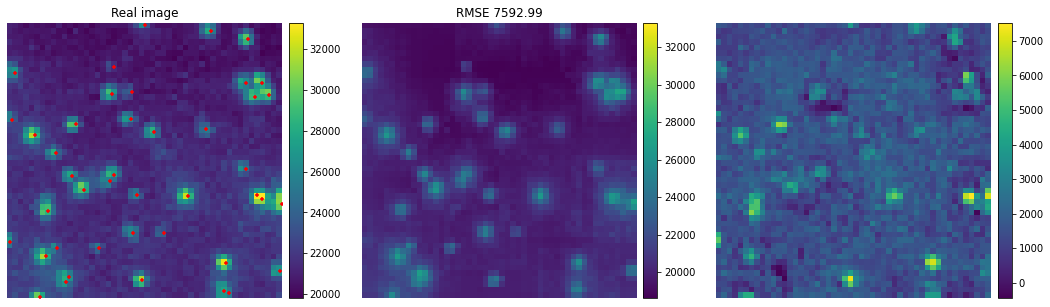

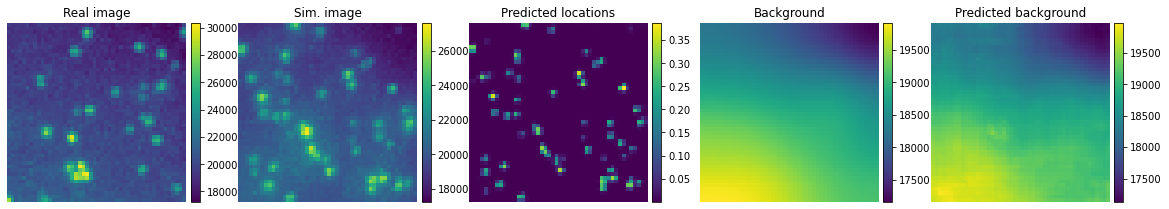

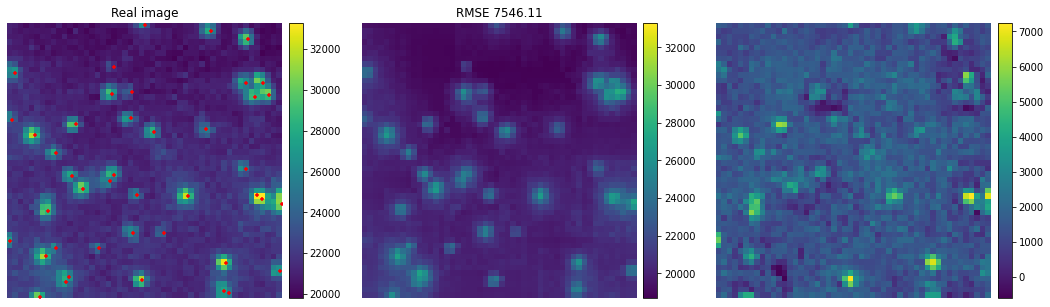

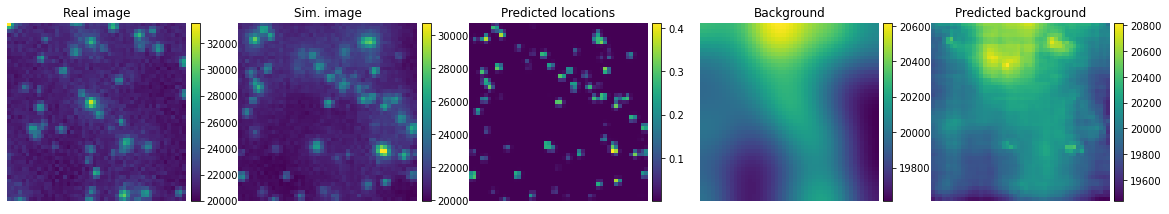

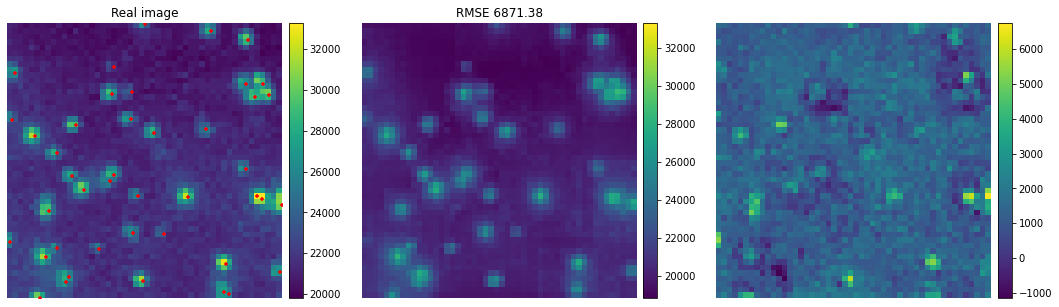

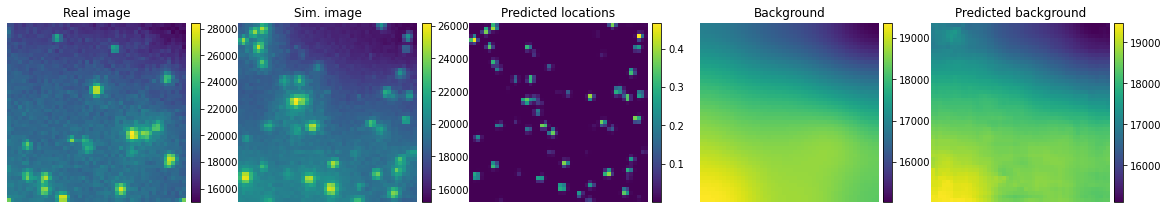

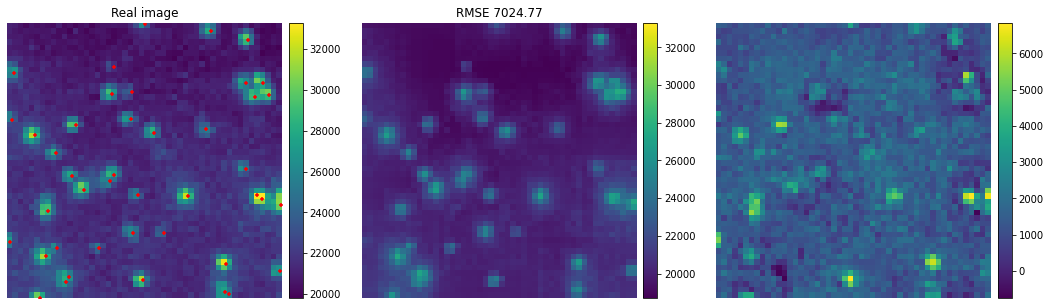

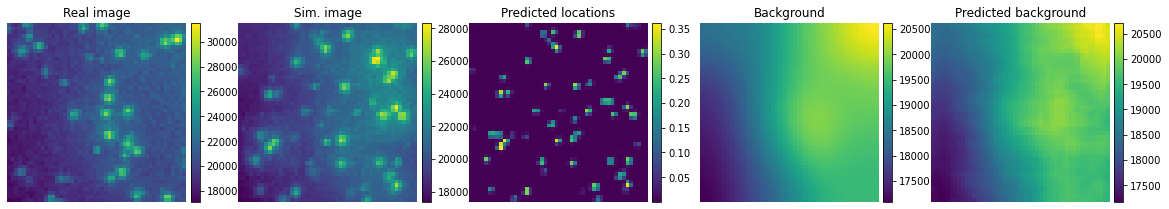

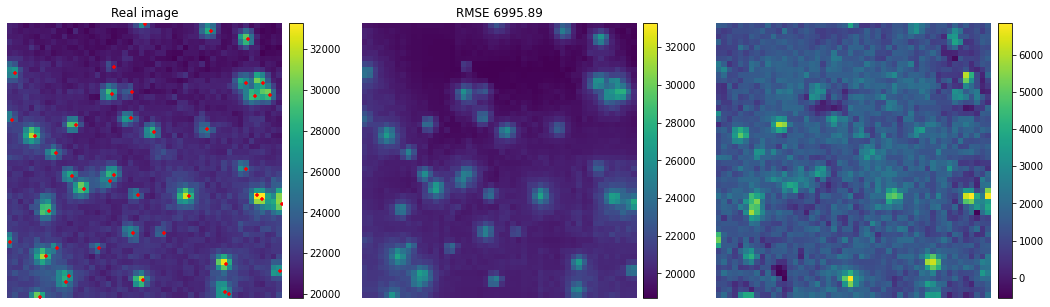

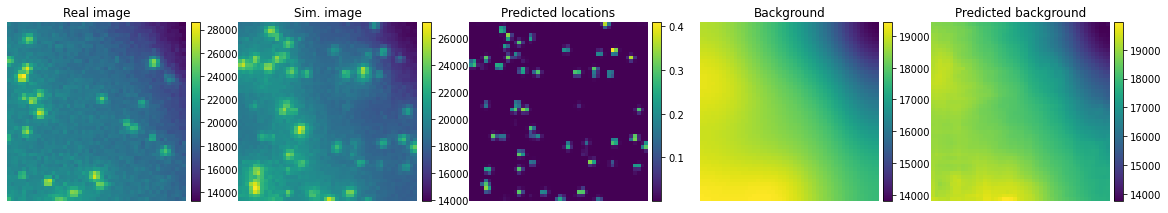

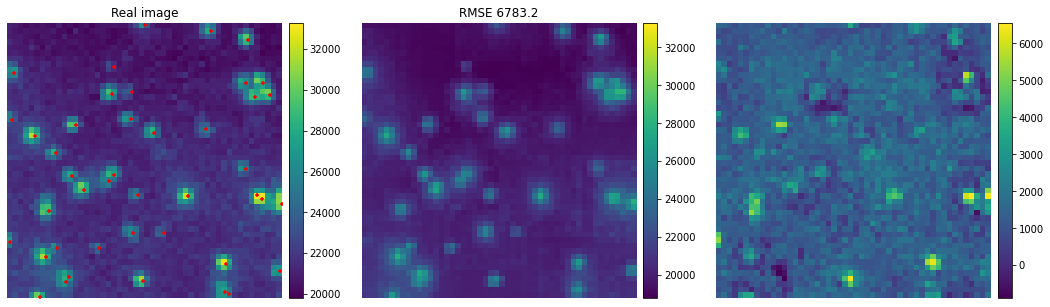

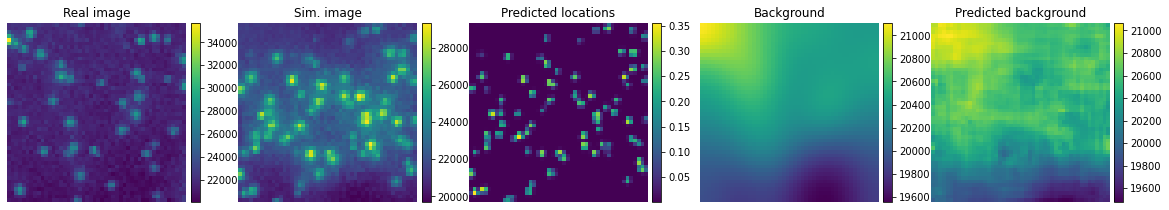

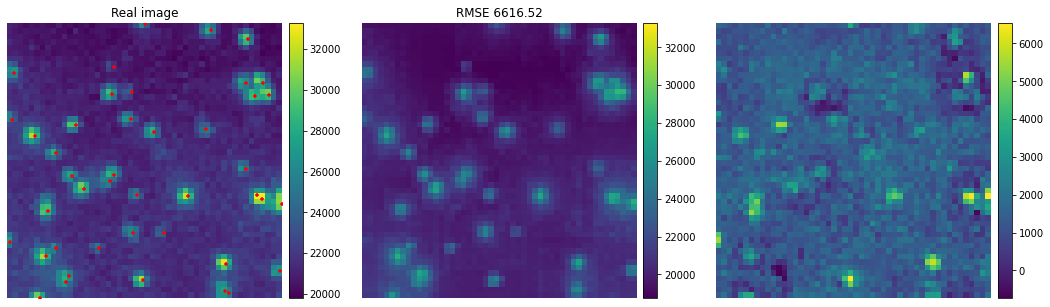

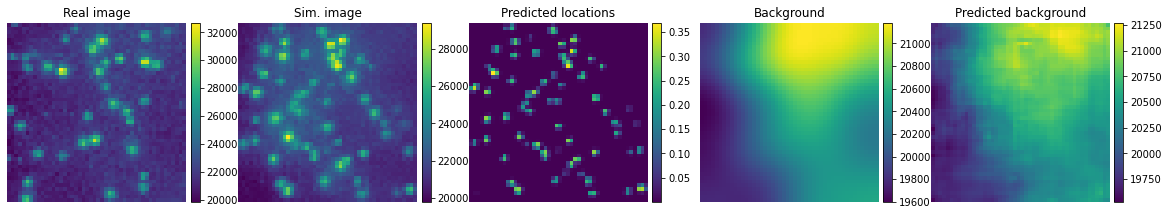

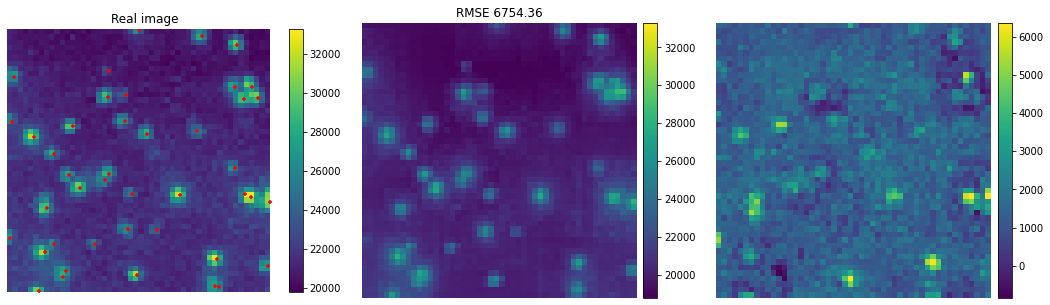

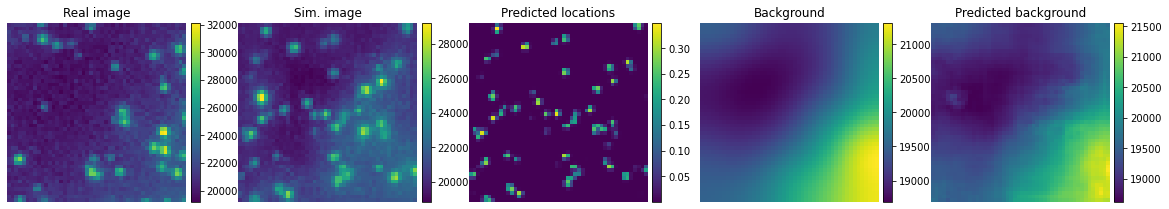

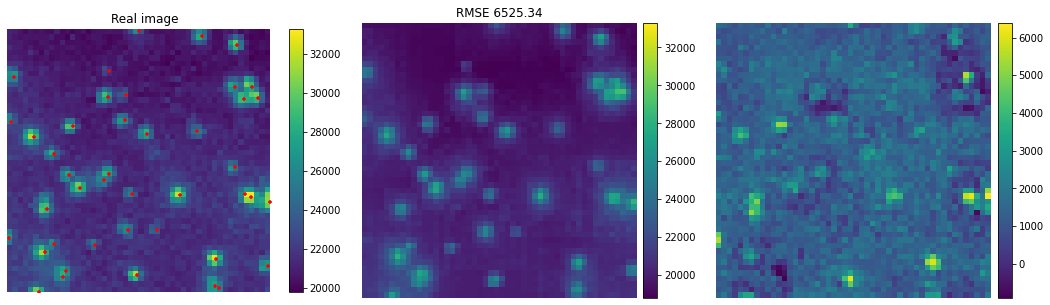

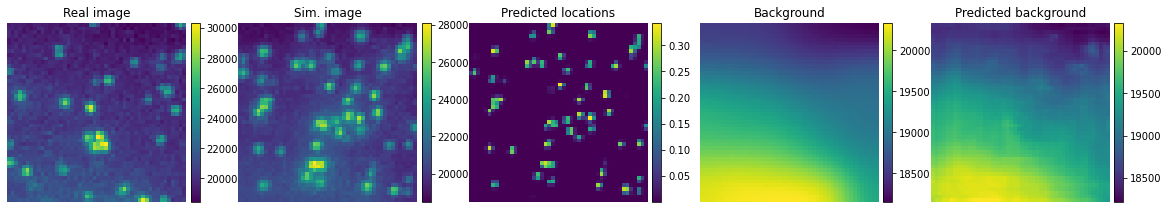

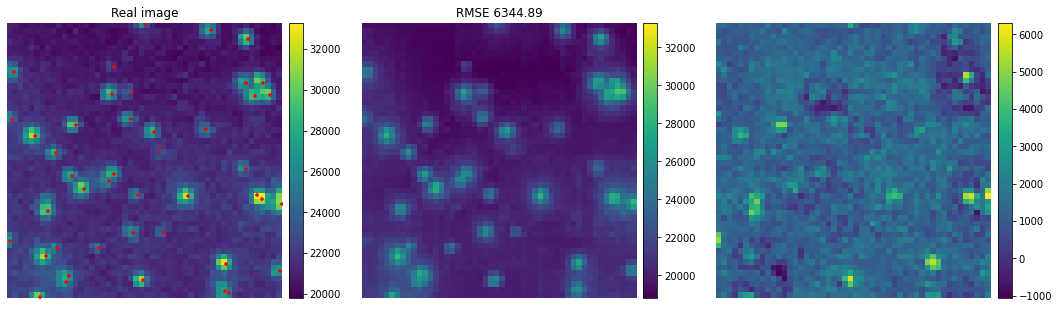

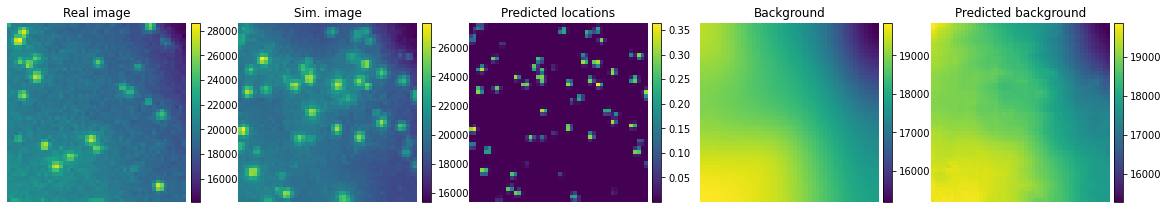

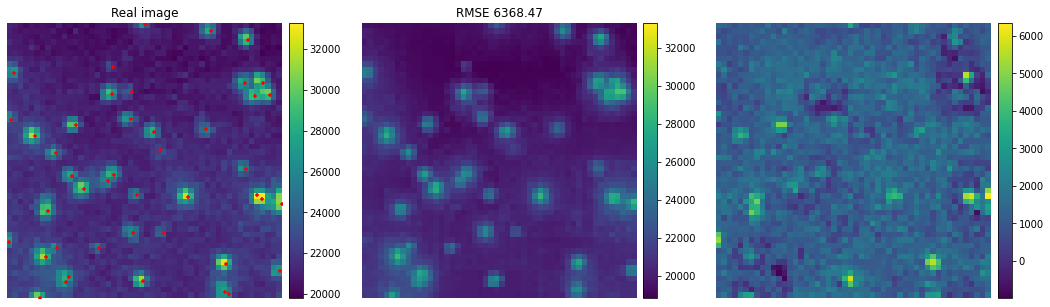

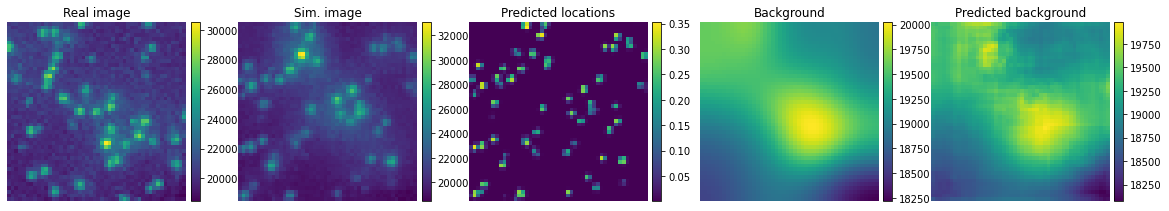

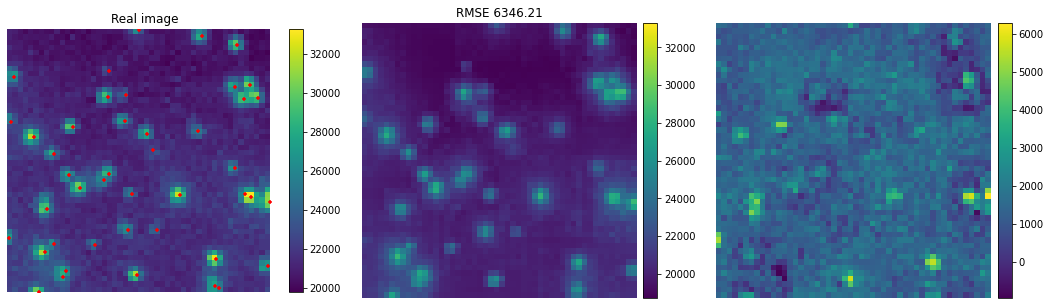

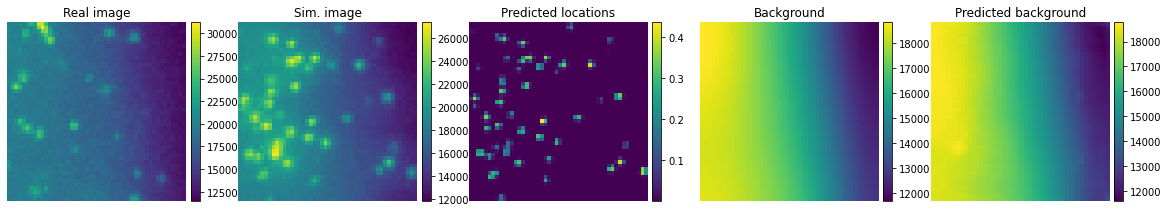

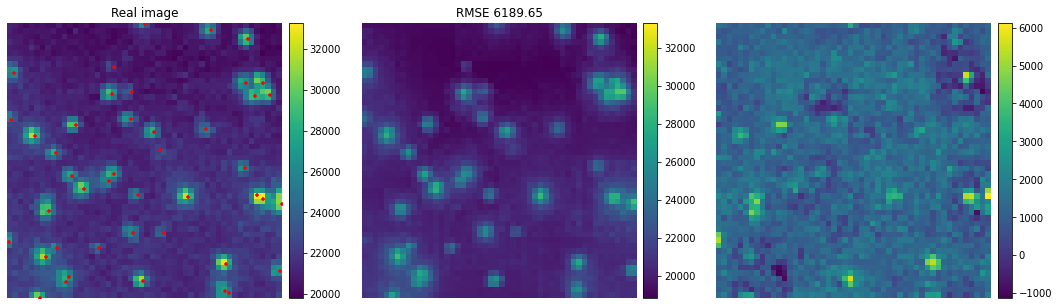

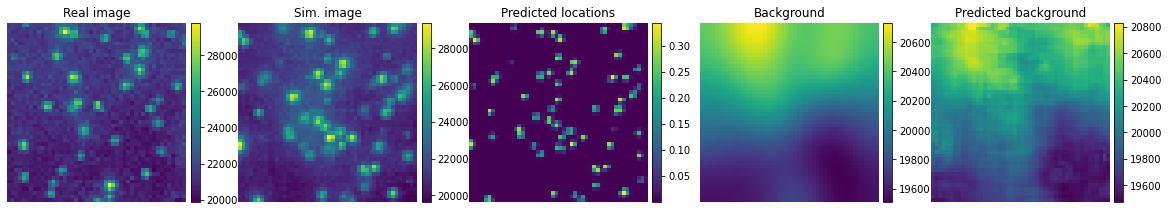

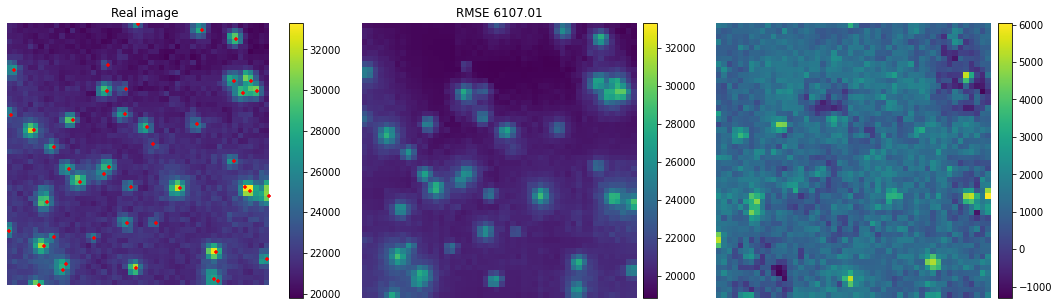

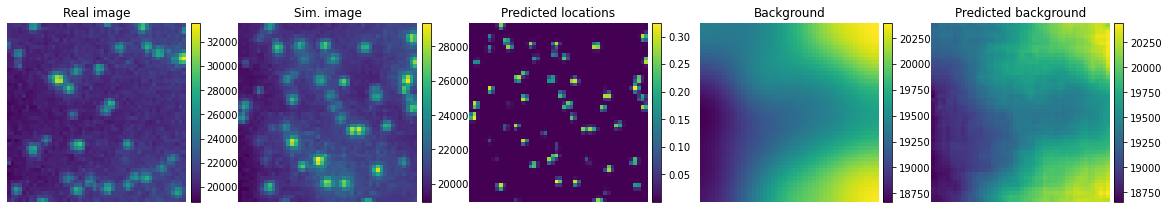

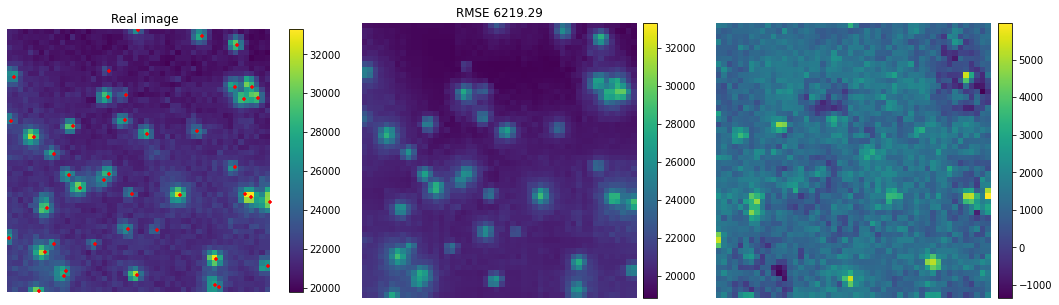

KeyboardInterrupt: 

In [ ]:
train_ae(model=model_sl, 
         dl=decode_dl, 
         num_iter=cfg.autoencoder.num_iter,
         optim_net=opt_sl, 
         optim_psf=opt_ae, 
         min_int=cfg.pointprocess.min_int, 
         psf=psf,
         sched_net=scheduler_sl, 
         sched_psf=scheduler_ae, 
         microscope=micro, 
         log_interval=cfg.supervised.log_interval,  
         save_dir=cfg.output.save_dir,
         log_dir=cfg.output.log_dir,
         bl_loss_scale=cfg.supervised.bl_loss_scale,
         p_quantile=cfg.supervised.p_quantile,
         grad_clip=cfg.supervised.grad_clip,
         eval_dict=eval_dict)

In [ ]:
!nbdev_build_lib